In [2]:
import pandas as pd
from scipy.stats import beta
import plotly.express as px
import numpy as np

/home/spirali/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
DATA = {
    "GPT-4": {
        "products - list.": {
            "Humans": [],
            "LLMs": [0.87, 0.90, 0.96, 0.56, 0.82, 0.86, 0.86, 0.79],
            "LLM-samples": 440,
        },
        "products - det.": {
            "Humans": [0.29],
            "Humans-samples": 214,
            "LLMs": [0.88, 0.89, 0.95, 0.53, 0.84, 0.83, 0.84, 0.89],
            "LLM-samples": 440,
        },
        "papers": {
            "Humans": [0.46],
            "Humans-samples": 249,
            "LLMs": [0.77, 0.70, 0.82, 0.52, 0.71, 0.79, 0.73, 0.82],
            "LLM-samples": 664 / 2,
        },
    },
    "GPT-3.5": {
        "products - list.": {
            "Humans": [],
            "LLMs": [0.55, 0.70, 0.69, 0.52, 0.59, 0.60, 0.64, 0.59],
            "LLM-samples": 440,
        },
        "products - det.": {
            "Humans": [0.28],
            "Humans-samples": 428,
            "LLMs": [0.62, 0.74, 0.79, 0.52, 0.67, 0.64, 0.70, 0.64],
            "LLM-samples": 440,
        },
        "papers": {
            "Humans": [0.60],
            "Humans-samples": 321,
            "LLMs": [0.60, 0.52, 0.67, 0.50, 0.61, 0.64, 0.55, 0.54],
            "LLM-samples": 744 / 2,
        },
    },
}

MODELS = [
    "GPT-4",
    "GPT-3.5",
    "Mixtral-8x22B",
    "Qwen1.5-4B",
    "Qwen1.5-14B",
    "Qwen1.5-72B",
    "Llama-3-8b",
    "Llama-3-70b",
]

OFFSET_NAMES = ["Humans"] + MODELS

rows = []
for gen_name, value in sorted(DATA.items()):
    for etype, value2 in sorted(value.items()):
        if value2["Humans"]:
            rows.append([gen_name, etype, "Humans", value2["Humans"][0], value2["Humans-samples"]])
        for model, val in zip(MODELS, value2["LLMs"]):
            rows.append([gen_name, etype, model, val, value2["LLM-samples"]])            
df = pd.DataFrame(rows, columns=["gen_name", "etype", "model", "ratio", "size"])
def compute_ci(value, size):
    alpha = value * size
    beta_ = (1 - value) * size
    a, b = beta.interval(0.95, alpha, beta_)
    return value - a, b - value 

df[["ci0", "ci1"]] = df.apply(lambda x: compute_ci(x["ratio"], x["size"]), axis=1, result_type='expand')
#df["Evaluator"] = df.model.apply(lambda x: x if ("Human" in x or "GPT" in x) else "Other LLM")
df["Evaluator"] = df.model
df["offset"] = df.model.apply(lambda x: (OFFSET_NAMES.index(x) - len(OFFSET_NAMES) / 2) / (len(OFFSET_NAMES) * 2))

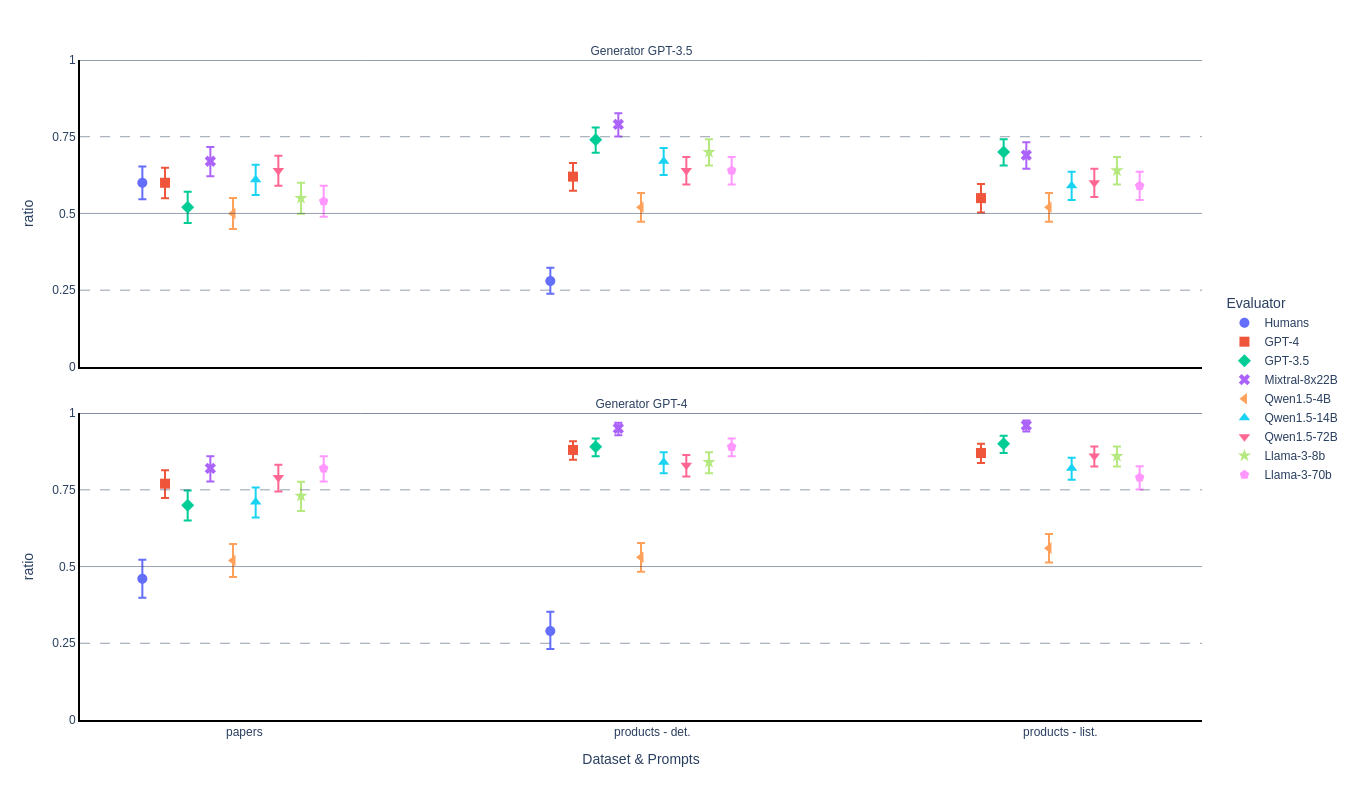

In [13]:
etype_order = {etype: i for i, etype in enumerate(df["etype"].unique())}
df["etype_numeric"] = df["etype"].map(etype_order)
np.random.seed(125)
df["etype_jittered"] = df["etype_numeric"] + df["offset"]

syms = ["circle", "square", "diamond", "x", "triangle-left", "triangle-up", "triangle-down", "star", "pentagon"]

fig = px.scatter(df, y="ratio", x="etype_jittered", error_y="ci1", error_y_minus="ci0", symbol="Evaluator", color="Evaluator", facet_col="gen_name", facet_col_wrap=1, width=900, height=800, labels={"etype_jittered": "Dataset & Prompts", "gen_name": "Generator"}, symbol_sequence=syms)
fig.update_traces(marker=dict(size=10))
fig.update_yaxes(range=[0, 1], dtick = 0.25)
fig.update_layout(
    plot_bgcolor="rgba(0, 0, 0, 0)",
)

fig.update_xaxes(
    tickvals=list(etype_order.values()),
    ticktext=list(etype_order.keys()))
fig.add_hline(0.5, line_width=0.5)
fig.add_hline(1, line_width=1)
fig.add_hline(0.25, line_width=0.5, line_dash="10px 10px")
fig.add_hline(0.75, line_width=0.5, line_dash="10px 10px")

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=False)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("=", " ")))
fig.update_layout(legend={"yanchor": "middle", "y": 0.5})

In [5]:
fig.write_image("results.svg")